# Portfolio Management 1
In this lab session we will practice portfolio optimization, and  better understand the knowledge acquried in the lecture, like  risk and returns , efficient frontier etc.
Part of the material is referenced from: https://mishraayush447.medium.com/



# Activity 1 Construct portfolio
In the first lab , if you constructed a portflio, you can now pull three months price data of all assets in your portfolio (using yahoofinance for example). You can use the yfinance python package or manually download data. For example, you can go to https://uk.finance.yahoo.com/ , type the asset ticker on the search bar and the asset information page will appear. Click on the 'Historical data' tab and modify the date range, click on 'Apply', then click 'Download'. 
If you didn't construct the portflio, or can not get price data of your assets, we also provide an example basket of assets for practicing.

In [34]:
# Load the price data of all assets into one df, make it clean and tidy. 
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf

# Define the tickers for the assets
tickers = {
    "gold": "GC=F",  # Gold futures
    "NVDA": "NVDA",  # NVIDIA Corporation
    "COLA": "KO",  # The Coca-Cola Company (assuming 'COLA' is meant to represent Coca-Cola)
    "bitcoin": "BTC-USD",  # Bitcoin in USD
    "vanguard_sp500": "VOO",  # Vanguard S&P 500 ETF
    "GBPUSD": "GBPUSD=X",  # GBP to USD exchange rate
    "HSBC": "HSBC"  # GBP to USD exchange rate
}

# Define the start and end dates for the 3-month period
start_date = "2023-12-01"
end_date = "2024-03-01"

# Retrieve the historical price data for each asset, put in a dict
historical_data = {}
for asset, ticker in tickers.items():
    historical_data[asset] = yf.download(ticker, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


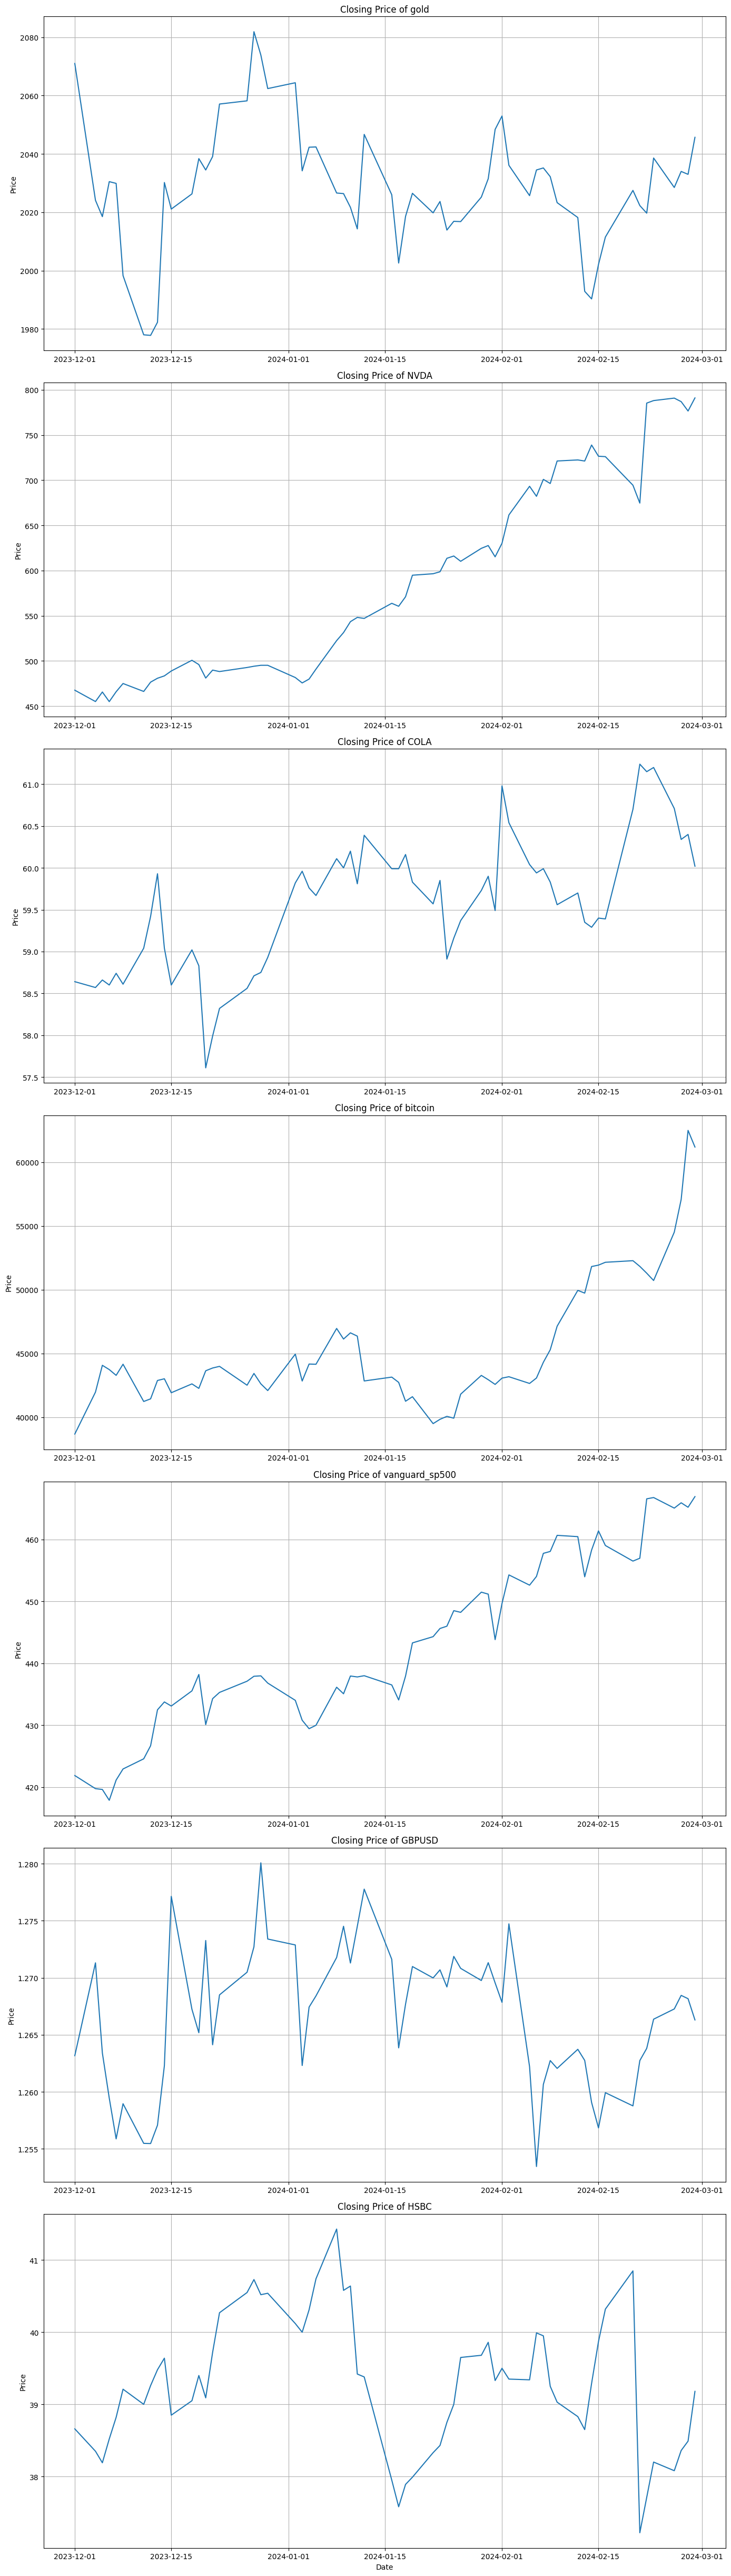

In [36]:
# Q1.1 Extracting 'Close' prices for each asset, and combining them into a single DataFrame
close_prices = pd.DataFrame()

for asset, data in historical_data.items():
    if not data.empty:
        close_prices[asset] = data['Close']

# Drop rows with any missing values (weekend is none trading days)
close_prices.dropna(inplace=True)


# Define the number of subplots based on the number of assets
num_assets = len(close_prices.columns)
fig, axes = plt.subplots(num_assets, 1, figsize=(14, 7 * num_assets))

# Plot each asset on its own subplot
for i, asset in enumerate(close_prices.columns):
    axes[i].plot(close_prices.index, close_prices[asset])
    axes[i].set_title(f'Closing Price of {asset}')
    axes[i].set_ylabel('Price')
    axes[i].grid(True)

# Set the xlabel for only the bottom subplot
axes[-1].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Save the data as backup
close_prices.to_csv('portfolio_components_close.csv')

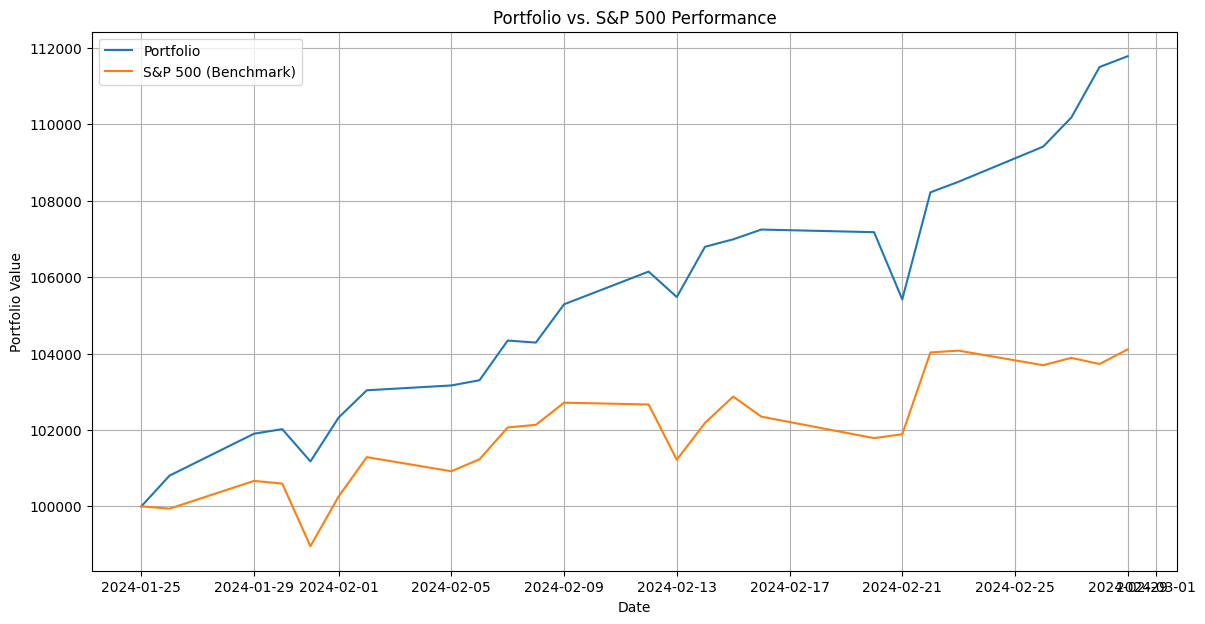

Portfolio Sharpe Ratio: 8.244467931066092


In [37]:
# Q1.2 Construct your portfolio use the portfolio weights and the price history, plot the portfolio performance against a benchmark (such as SP500)
# You can use initial conditions of our simulation (date 2024-01-25,initial capital 100000) .

# Assume equal weights for simplicity, but you can adjust them to your portfolio weights

portfolio_weights = [0.143,0.143,0.143,0.143,0.143,0.143,0.142]

# Slice the DataFrame to start from January 25, 2024  (our first lab)
simulation_date = '2024-01-25'
simulation_prices = close_prices[close_prices.index >= simulation_date]

# Calculate daily returns of assets. The .fillna(0)  is to fill the first row (will be null after pct_change)with 0
daily_returns = simulation_prices.pct_change().fillna(0)


# Calculate portfolio's daily returns
portfolio_daily_returns = daily_returns.dot(portfolio_weights)

# Calculate cumulative returns for the portfolio
initial_investment = 100000
portfolio_value = (1 + portfolio_daily_returns).cumprod() * initial_investment

# Benchmark performance (S&P 500) , assume all your investment goes to market index. 
sp500_benchmark =simulation_prices['vanguard_sp500']/simulation_prices['vanguard_sp500'].iloc[0]* initial_investment

# Plot portfolio and S&P 500 performance
plt.figure(figsize=(14, 7))
plt.plot(portfolio_value, label='Portfolio')
plt.plot(sp500_benchmark, label='S&P 500 (Benchmark)')
plt.title('Portfolio vs. S&P 500 Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()




Q1.3 Calculate the sharpraio of the portfolio based on the performance from 2024-01-25.\
$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

Where:

- $R_p$ is the expected portfolio return,
- $R_f$ is the risk-free rate,
- $\sigma_p$ is the standard deviation of the portfolio's excess returns (its risk or volatility).\

Please be aware that when calculate Sharp Raio, the reutrn and volatility need to be in the same time frame, i.e. all in daily/monthly/or yearly.

In [86]:
# Calculate the Sharp Ratio of the equal weighted portfolio based on the performance of Jan 25 to Mar 01.

risk_free_rate = 0.05/252 # Assuming a risk-free rate of 5% annually, noncompound annual interest in 252 trading days
portfolio_daily_excess_return_ = portfolio_daily_returns - risk_free_rate 
sharpe_ratio = portfolio_daily_excess_return_.mean() / portfolio_daily_returns.std()*np.sqrt(252)  # Annualized sharpratio

print(f"Portfolio Sharpe Ratio: {sharpe_ratio}")

Portfolio Sharpe Ratio: 8.244467931066092


# Construct the optimized portfolio
In this task, suppose we need to construct a portfolio from the listed assets only.  Use risk-return analysis , efficient frontier to  optimize the portfolio weight.\
In our simplified model, assume the historical risk and return of all assets remains the same before and after Jan/25. 


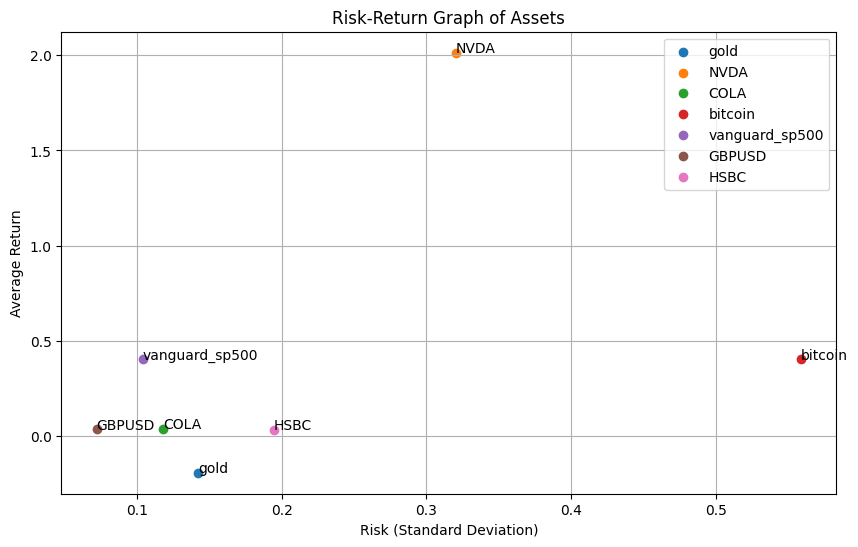

In [81]:
# Slice the historical data, use the price data a month ahead of our portfolio construction ( 2023 Dec and 2024 Jan) as training set.

# Q2.1 Calculate the (average) return and risk of each asset, plot them on a risk-return graph.


# Slice the DataFrame before January 25, 2024  (our first lab) as training set.
simulation_date = '2024-01-25'
training_prices = close_prices[close_prices.index <simulation_date]


# Calculate daily returns
daily_returns = training_prices.pct_change()

# Calculate average return and risk for each asset
average_returns = daily_returns.mean()*252   # Annualize the average returns
risks = daily_returns.std()*np.sqrt(252)   # Annualize the risk

# Plotting
plt.figure(figsize=(10, 6))
for i, asset in enumerate(close_prices.columns):
    plt.scatter(risks[asset], average_returns[asset], label=asset)

    # Label assets
    plt.text(risks[asset], average_returns[asset], asset)

plt.title('Risk-Return Graph of Assets')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Average Return')
plt.grid(True)
plt.legend()
plt.show()


In [82]:
# Q2.2 Calculate the expected return and the covariance (.cov) matrix of the assets.

print(daily_returns.mean()*252) # Anualized expected return

daily_returns.cov()*252 # Anualized cov matrix


gold             -0.191435
NVDA              2.012826
COLA              0.039879
bitcoin           0.405347
vanguard_sp500    0.406041
GBPUSD            0.036791
HSBC              0.035284
dtype: float64


,gold,NVDA,COLA,bitcoin,vanguard_sp500,GBPUSD,HSBC
gold,0.020152,0.001687,0.000293,-0.014702,0.003587,0.001595,0.008695
NVDA,0.001687,0.102486,0.000968,0.019032,0.022166,-0.001531,0.011542
COLA,0.000293,0.000968,0.013949,-0.000714,0.004860,-0.002752,0.005654
bitcoin,-0.014702,0.019032,-0.000714,0.312477,-0.001756,0.004796,0.004829
vanguard_sp500,0.003587,0.022166,0.004860,-0.001756,0.010777,-0.000509,0.010326
GBPUSD,0.001595,-0.001531,-0.002752,0.004796,-0.000509,0.005171,-0.001445
HSBC,0.008695,0.011542,0.005654,0.004829,0.010326,-0.001445,0.037783


In [89]:
# Calculate the risk, return and sharp ratio of the equal weighted portfolio, check where it is at the risk-return graph

portfolio_weights = np.array( [0.143,0.143,0.143,0.143,0.143,0.143,0.142])


# Calculate portfolio return
print('Portfolio Return')
port_ret = np.sum(daily_returns.mean() *252* portfolio_weights)
print(port_ret)

# Calculate expected volatility
print('Portfolio Volatility')
port_vol = np.sqrt(np.dot(portfolio_weights.T, np.dot(daily_returns.cov()*252, portfolio_weights)))
print(port_vol)

# Calculate sharp ratio
print('Sharp Ratio')

print((port_ret-0.05)/port_vol)

Portfolio Return
0.392461639436265
Portfolio Volatility
0.1157290106186349
Sharp Ratio
2.9591684712901296


In [112]:
# Q2.3 Use Monte Carlo simulation to generate efficient frontier for portfolio optimization.
# Monte Carlo simulation in this lab's context is to perform large numbers of experiments of random portfolio weights, to find the optimized weights.

num_ports = 20000
num_assets =7
all_weights = np.zeros((num_ports, num_assets))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for i in range(num_ports):
    # Create random weights
    weights = np.array(np.random.random(num_assets))
    # normalize weights to a sum of 1
    weights = weights / np.sum(weights)
    
    # Save weights
    all_weights[i, :] = weights
    
    # Expected return
    ret_arr[i] = np.sum(daily_returns.mean() * 252 * weights)
    
    # Expected volatility
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))
    
    # Sharpe ratio
    sharpe_arr[i] = (ret_arr[i] - 0.05) / vol_arr[i]

# Get max sharpe ratio
max_sharpe = sharpe_arr.max()

# Get the location of the max sharpe ratio
max_sharpe_loc = sharpe_arr.argmax()

# Get the weights for the max sharpe ratio
max_sharpe_weights = all_weights[max_sharpe_loc, :]


print(f"The max Sharpe ratio is {max_sharpe:.3f}, portfolio return and risk are {ret_arr[max_sharpe_loc],vol_arr[max_sharpe_loc]}.")
print(f"The max Sharpe ratio portfolio composition of {list(daily_returns.columns)}, with weights {max_sharpe_weights}.")

The max Sharpe ratio is 11.445, portfolio return and risk are (1.3746944753807977, 0.11574282026172539).
The max Sharpe ratio portfolio composition of ['gold', 'NVDA', 'COLA', 'bitcoin', 'vanguard_sp500', 'GBPUSD', 'HSBC'], with weights [0.27947534 0.11378585 0.1976846  0.21964289 0.05739895 0.12836799
 0.00364438].


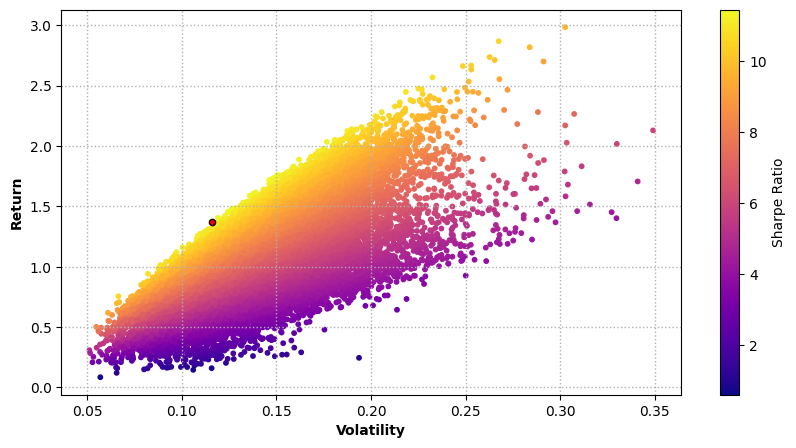

In [113]:
# Q2.4 Plot out all the risks and returns of the Monte carlo simulation in risk-return graph, highlight the max sharp portfolio.


plt.figure(figsize=(10, 5))
scatter = plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma',s=10)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontweight='bold')
plt.ylabel('Return', fontweight='bold')

# Assuming sharpe_max_vol and sharpe_max_ret have been defined as the volatility and return
# of the portfolio with the maximum Sharpe Ratio
plt.scatter(vol_arr[max_sharpe_loc],ret_arr[max_sharpe_loc], c='red', s=20, edgecolors='black')
plt.grid(True, ls=':', lw=1)
plt.show()


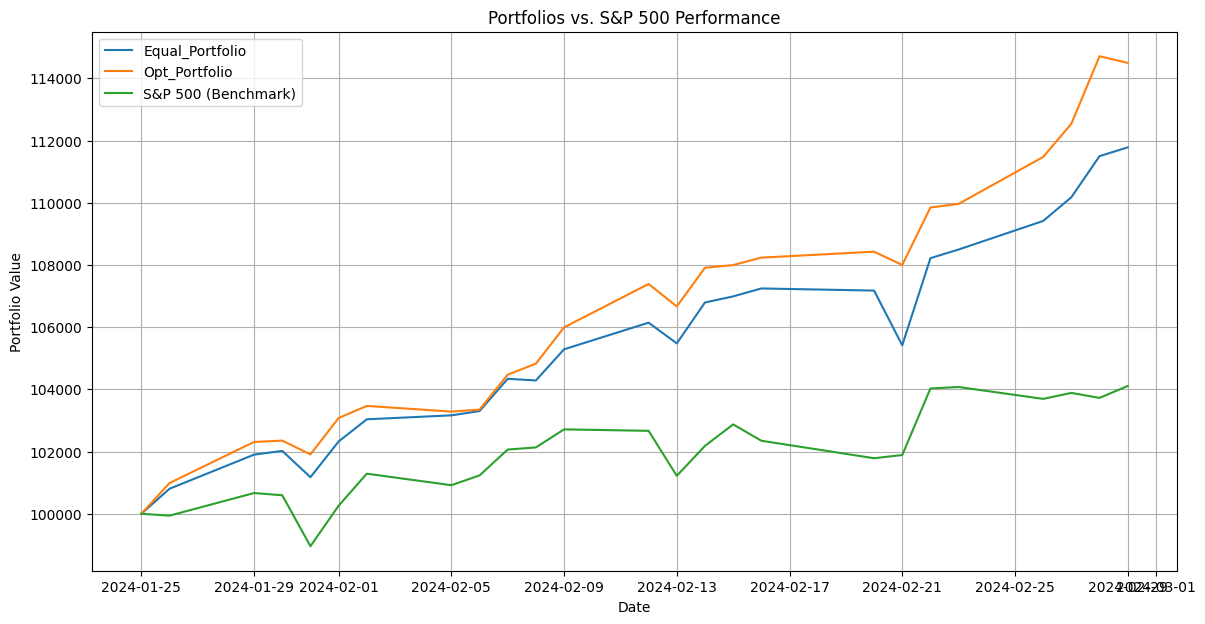

In [114]:
# Q2.5 Use the optimized portfolio weight , plot out portfolio performance.
# Plot out the equal weighted portfolio and the bench mark like in Q1.2. Compare the performance of portfolio optimization.


# Assume equal weights for simplicity, but you can adjust them to your portfolio weights

equal_weights = [0.143,0.143,0.143,0.143,0.143,0.143,0.142]

# Slice the DataFrame to start from January 25, 2024  (our first lab)
simulation_date = '2024-01-25'
simulation_prices = close_prices[close_prices.index >= simulation_date]

# Calculate daily returns of assets. The .fillna(0)  is to fill the first row (will be null after pct_change)with 0
daily_returns = simulation_prices.pct_change().fillna(0)


# Calculate equal weight and optimized weight portfolio's daily returns
equal_port_daily_returns = daily_returns.dot(equal_weights)
opt_port_daily_returns = daily_returns.dot(max_sharpe_weights)

# Calculate cumulative returns for the portfolio
initial_investment = 100000
equal_portfolio_value = (1 + equal_port_daily_returns).cumprod() * initial_investment
opt_portfolio_value = (1 + opt_port_daily_returns).cumprod() * initial_investment

# Benchmark performance (S&P 500) , assume all your investment goes to market index. 
sp500_benchmark =simulation_prices['vanguard_sp500']/simulation_prices['vanguard_sp500'].iloc[0]* initial_investment

# Plot portfolio and S&P 500 performance
plt.figure(figsize=(14, 7))
plt.plot(equal_portfolio_value, label='Equal_Portfolio')
plt.plot(opt_portfolio_value, label='Opt_Portfolio')
plt.plot(sp500_benchmark, label='S&P 500 (Benchmark)')
plt.title('Portfolios vs. S&P 500 Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()
